In [201]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import io as sio

from utils import GenerateHaarFeatureMasks, ExtractHaarFeatures
from classifier import WeakClassifier, WeakClassifierError

plt.rcParams['figure.facecolor']='white'

In [218]:
# Hyper-parameters

# Number of randomized Haar-features
nbrHaarFeatures = 200

# Number of training images, will be evenly split between faces and
# non-faces. (Should be even.)
nbrTrainImages = 1000

# Number of weak classifiers
nbrWeakClassifiers = 50

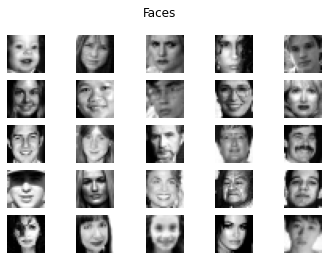

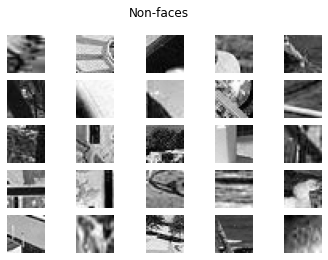

In [219]:
# Load face and non-face data and plot a few examples
faces = sio.loadmat('faces.mat')['faces']
nonfaces = sio.loadmat('nonfaces.mat')['nonfaces']

faces = faces.astype('double')[:,:,np.random.permutation(faces.shape[-1])]
nonfaces = nonfaces.astype('double')[:,:,np.random.permutation(nonfaces.shape[-1])]

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(faces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Faces')

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(nonfaces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Non-faces')
plt.show()

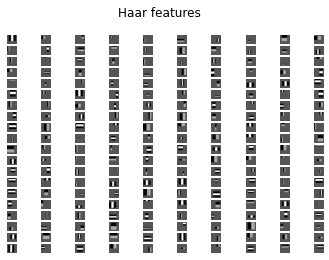

In [220]:
# Generate Haar feature masks
haarFeatureMasks = GenerateHaarFeatureMasks(nbrHaarFeatures)

plt.figure()
for k in range(nbrHaarFeatures):
    plt.subplot(20,10,k+1)
    plt.imshow(haarFeatureMasks[:,:,k], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
plt.show()

In [221]:
# Create image sets (do not modify!)

# Create a training data set with examples from both classes.
# Non-faces = class label y=-1, faces = class label y=1
trainImages = np.concatenate((faces[:,:,:nbrTrainImages//2], nonfaces[:,:,:nbrTrainImages//2]), axis=2)
xTrain = ExtractHaarFeatures(trainImages,haarFeatureMasks)
yTrain = np.concatenate((np.ones(nbrTrainImages//2), -np.ones(nbrTrainImages//2)))

# Create a test data set, using the rest of the faces and non-faces.
testImages  = np.concatenate((faces[:,:,nbrTrainImages//2:], nonfaces[:,:,nbrTrainImages//2:]), axis=2)
xTest = ExtractHaarFeatures(testImages,haarFeatureMasks)
yTest = np.concatenate((np.ones(faces.shape[2]-nbrTrainImages//2), -np.ones(nonfaces.shape[2]-nbrTrainImages//2)))

# Variable for the number of test-data.
nbrTestImages = yTest.shape

In [222]:
# Implement the AdaBoost training here
# Use your implementation of WeakClassifier and WeakClassifierError in classifier.py


d=np.ones(nbrTrainImages)/nbrTrainImages #initial d_t(i)=1/num_XTrain
cutoff_list=np.zeros(nbrWeakClassifiers)
p_list=np.zeros(nbrWeakClassifiers)
alpha_list=np.zeros(nbrWeakClassifiers)
h_index_list=np.zeros(nbrWeakClassifiers)
        
for niter in range(nbrWeakClassifiers): 
    error_min=np.inf
    for haar in range(nbrHaarFeatures):
        for t in xTrain[haar,:]:
            P=1
            C=WeakClassifier(t, P, xTrain[haar,:])
            error=WeakClassifierError(C, d, yTrain)
            if error>0.5:
                P=-1
                error=1-error
            if error<error_min: 
                error_min=error
                haar_min=haar
                t_min=t
                p_min=P
        
    alpha_min=0.5*math.log((1-error_min)/error_min)
    h_min=WeakClassifier(t_min,p_min,xTrain[haar_min,])
    d=np.multiply(d,np.exp(-alpha_min*np.multiply(yTrain,h_min))) # updata d
    d=d/sum(d) #renormalize d
        
    cutoff_list[niter]=t_min
    p_list[niter]=p_min
    alpha_list[niter]=alpha_min
    h_index_list[niter]=int(haar_min)

In [223]:
# Evaluate your strong classifier here
# Evaluate on both the training data and test data, but only the test accuracy
# can be used as a performance metric since the training accuracy is biased.

In [224]:
print(f"weak classifiers index:{h_index_list}")

weak classifiers index:[169.  10.  39.  87.  13. 195.  43.  55. 123. 124.  95. 161. 175. 147.
  99.  24.  44.   4. 103.   6.  13. 198. 191. 169. 129.  23. 114. 113.
  29.  41.  25.  43. 153.  23.  26.  20.   1. 109.  28. 111.  17.   7.
 154. 150. 140.  63. 168.  20. 196.  42.]


In [233]:
def fit(cutoff,p,alpha,h_index,x):
    data=np.array([x[int(i),] for i in h_index])
    h_data=[WeakClassifier(cutoff[i],p[i],data[i,]) for i in range(len(p))]
    H_data=np.sign(sum(np.multiply(alpha.reshape(len(alpha),1),h_data)))
    return H_data

# Evaluate on the training data 
fit_train=fit(cutoff_list[0:30], p_list[0:30], alpha_list[0:30],h_index_list[0:30],xTrain)
# Evaluate on test data
fit_test=fit(cutoff_list[0:30], p_list[0:30], alpha_list[0:30],h_index_list[0:30],xTest)
# accuracy on train data
n_tr=len(yTrain)
actr=sum([1 if fit_train[i]==yTrain[i] else 0 for i in range(n_tr)])/n_tr
# accuracy on test data
n_te=len(yTest)
acte=sum([1 if fit_test[i]==yTest[i] else 0 for i in range(n_te)])/n_te
(actr,acte)

(0.984, 0.9334068544282321)

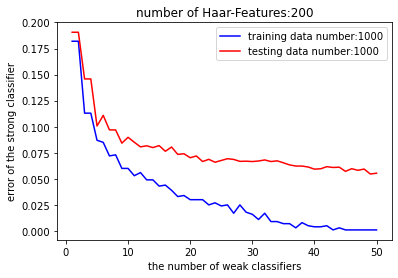

In [230]:
# Plot the error of the strong classifier as a function of the number of weak classifiers.
# Note: you can find this error without re-training with a different number of weak classifiers.

def StrongClassifierError(cutoff,p,alpha,h_index,X,Y):
    fit_data=fit(cutoff,p,alpha,h_index,X)
    n_data=len(Y)
    error=sum([1 if fit_data[i]!=Y[i] else 0 for i in range(n_data)])/n_data
    return error

# calculate in training data
error_list_train=[StrongClassifierError(cutoff_list[0:i],p_list[0:i],alpha_list[0:i],h_index_list[0:i],xTrain,yTrain) for i in range(1,nbrWeakClassifiers+1)]
# calculate on test data
error_list_test=[StrongClassifierError(cutoff_list[0:i],p_list[0:i],alpha_list[0:i],h_index_list[0:i],xTest,yTest) for i in range(1,nbrWeakClassifiers+1)]

plt.plot(range(1,nbrWeakClassifiers+1),error_list_train,color="blue",label="training data number:1000")
plt.plot(range(1,nbrWeakClassifiers+1),error_list_test,color="red",label="testing data number:1000")
plt.xlabel("the number of weak classifiers")
plt.ylabel("error of the strong classifier")
plt.title(f"number of Haar-Features:{nbrHaarFeatures}")
plt.legend()
plt.show()


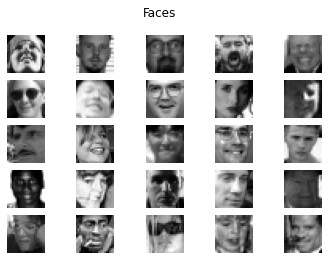

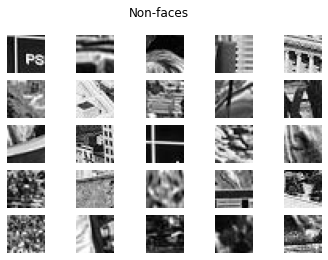

In [231]:
# Plot some of the misclassified faces and non-faces
# Use the subplot command to make nice figures with multiple images.
zip(fit_test,yTest)
mis_faces=testImages[:,:,[i for i in range(len(yTest)) if fit_test[i]==-1 and yTest[i]==1]]
mis_nonfaces=testImages[:,:,[i for i in range(len(yTest)) if fit_test[i]==1 and yTest[i]==-1]]

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(mis_faces[:,:,5*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Faces')

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(mis_nonfaces[:,:,5*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Non-faces')
plt.show()


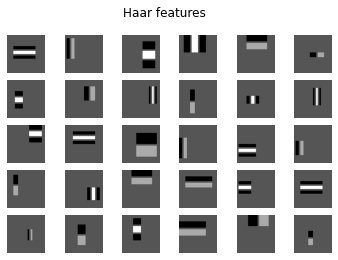

In [232]:
# Plot your choosen Haar-features
# Use the subplot command to make nice figures with multiple images.
index=[int(x) for x in h_index_list]
haar=haarFeatureMasks[:,:,index]

plt.figure()
for k in range(30):
    plt.subplot(5,6,k+1)
    plt.imshow(haar[:,:,k], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
plt.show()


In [200]:
##################################################